In [1]:
import json
import datetime
import altair as alt
import pandas as pd
import numpy as np
import os

hits = [
'2018-08-10_00-00-00', #0
'2018-08-29_11_32_44',
'2018-08-29_22-54-16', #2
'2018-09-05_21-38-43',
'2018-09-07_11-34-48',
'2018-09-08_09-41-18',
'2018-09-09_10-28-14', #6
'2018-09-10_10-36-44', #7
'2018-09-11_11-09-18',
#'2018-09-12_11-04-34',
'2018-09-13_12-06-31',
]
base = 'hits/' + hits[8]
def cd(file):
    return os.path.join(base, file)

In [2]:
def duration_plot(assignments):
    times = []
    submit_times = []
    for l in assignments:
        submit = datetime.datetime.strptime(l['SubmitTime'][:-6], "%Y-%m-%d %H:%M:%S")
        accept = datetime.datetime.strptime(l['AcceptTime'][:-6], "%Y-%m-%d %H:%M:%S")
        submit_times.append(submit)
        diff = (submit - accept).total_seconds()/60.0
        times.append({"diff": diff})
    spec = {
      "data": {"values": times},
      "mark": "bar",
      "encoding": {
        "x": {
          "field": "diff",
          "type": "quantitative",
          "bin": {"step": 1} 
        },
        "y": {
          "aggregate": "count",
          "type": "quantitative"
        }
      }
    }
    print('min - max: ', min(submit_times), max(submit_times))
    print('mean duration: ', np.mean(list(map(lambda d: d['diff'], times))))
    return alt.VegaLite(spec)

min - max:  2018-09-11 11:11:27 2018-09-11 13:39:09
mean duration:  10.390555555555556


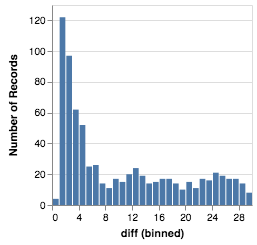

min - max:  2018-09-11 14:54:49 2018-09-11 17:05:55
mean duration:  12.568800000000001


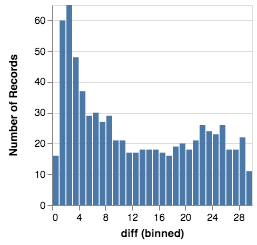

In [3]:
listener_assignments = json.load(open(cd('listener.assignments')))
speaker_assignments = json.load(open(cd('speaker.assignments')))
display(duration_plot(speaker_assignments))
display(duration_plot(listener_assignments))

In [4]:
import collections 

def by_worker(assign):
    workers = collections.defaultdict(int)
    for a in assign:
        workers[a['WorkerId']] += 1
    descending = sorted(workers.items(), key=lambda a: -a[1])
    return collections.OrderedDict(descending) 

listener_counts = by_worker(listener_assignments)
speaker_counts = by_worker(speaker_assignments)
intersection = set(speaker_counts.keys()).intersection(listener_counts.keys())

for k in intersection:
    print(k, listener_counts[k], speaker_counts[k])
print('speak: {} listener {} overlap {}'.format(len(speaker_counts), len(listener_counts), len(intersection)))

A36CQIFWEDEECU 11 20
A33UQADFRXM0N 37 2
A35JQ3VLA4WBZC 14 21
A03922113RU44GENR8ATX 13 6
AVBRJBJONL47I 9 2
ARB52L0KXB1DE 4 12
AUPHYAKC58LPA 6 10
A1IN92CQSAJE9Z 8 1
ASL76QYDI0QLK 15 16
AG5PMV0NS3A44 10 21
A2R3KI7FWWGBIV 26 50
A1TGV7LT6LTIQU 17 14
A3F9N2P4NUUR7S 26 35
A2S96ZZ70YFPSK 17 7
AISNLDPD2DFEG 4 17
APJJ1HHD2GGFS 3 2
A3CGA66ES1ZTKC 6 6
A15WCNO32MHBAF 3 11
AUI3R928P63B0 26 37
A3W24IE6P9O302 43 65
A1TVJ4HKOOIL6L 7 15
A2KAZBONNVNV5O 17 2
A98E8M4QLI9RS 28 21
A2L5J9XWM1ODIL 8 43
A374STD2W8N1U8 23 1
A1P0XSCJ9XAV74 16 6
speak: 68 listener 104 overlap 26


In [5]:
import pandas as pd
import collections
import mturk
from mturk.query_line import QueryLine
pd.set_option('display.max_colwidth', 200)
pd.set_option("display.max_rows", None)

def isfloat(string):
    try:
        float(string)
        return True
    except ValueError:
        return False
    
def reduce_formula(x):
    if x.find(':') == -1:
        print('COLON_NOT_FOUND', x)
        return 'COLON_NOT_FOUND'
    v = x[x.index(':')+1:]
    return x[:x.index(':')] + ('number' if isfloat(v) else v)

def to_html(spec):
    options = {'rendered': 'svg', 'width': 800, 'height': 800}
    return alt.utils.html.spec_to_html(spec, 'vega-lite', '3', '3', '2', embed_options=options)


processing 2018-08-29_22-54-16
processing 2018-09-05_21-38-43
processing 2018-09-07_11-34-48
processing 2018-09-08_09-41-18
processing 2018-09-09_10-28-14
processing 2018-09-10_10-36-44
processing 2018-09-11_11-09-18
processing 2018-09-13_12-06-31


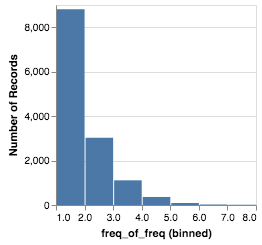

20254 13424 8814
number of listener pick_or_skip 44653
got 20254 examples, 147697 listeners log


In [66]:
from mturk import process_listener as pl
from mturk import guess_id as guess
# adds annotations

def aggregate_all():
    examples = []
    listener_log = []
    for h in hits[2:]:
        print('processing', h)
        speaker_path = os.path.join('hits', h, 'speaker.jsonl')
        listener_path = os.path.join('hits', h, 'listener.raw.jsonl')
        lines = [QueryLine(line.strip()) for line in open(speaker_path, 'r').readlines()]
        examples += [l for l in lines if l.is_example()]
        listener_log += [QueryLine(line.strip()) for line in open(listener_path, 'r').readlines()]
#     formulas = [l.example()['targetFormula'] for l in examples]
#     paths = list(map(lambda x: reduce_formula(x), formulas))
    paths = [reduce_formula(l.example()['targetFormula'])
             + guess.hash_query(l.json, keys=['context']) for l in examples]
    pathsset = set(paths)
    pathcounter = collections.Counter(paths)
    countisone = [k for k in pathcounter.keys() if pathcounter[k] == 1]
    freqfreq = pathcounter.values()
    spec = {
      "data": {"values": [{"freq_of_freq": v} for v in freqfreq]},
      "mark": "bar",
      "encoding": {
        "x": {
          "field": "freq_of_freq",
          "type": "quantitative",
          "bin": {"step": 1} 
        },
        "y": {
          "aggregate": "count",
          "type": "quantitative"
        }
      }
    }
    chart = alt.VegaLite(spec)
    display(chart)
    print(len(paths), len(pathsset), len(countisone))
    
    pl.process_listener(examples, listener_log)
    speakers, listeners = pl.aggregate_turker(examples)
    print('got {} examples, {} listeners log'.format(len(examples), len(listener_log)))
    return speakers, listeners

speakers, listeners = aggregate_all()

s_count, l_count 267 906
136 in common


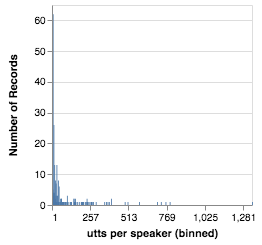

mean, median number of utterances 75.858 20.0
total 20254 utterances, mean_len 36.60 chars, 7.26 tokens
43275
correct, wrong, skip: 0.761, 0.170, 0.068


In [65]:
def hist(data, field):
    records = [{field: i} for i in data]
    spec = {
      "data": {"values": records},
      "mark": "bar",
      "encoding": {
        "x": {
          "field": field,
          "type": "quantitative",
          "bin": {"step": 1} 
        },
        "y": {
          "aggregate": "count",
          "type": "quantitative"
        }
      }
    }
    return alt.VegaLite(spec)

def type2acc(stats):
    total = stats['correct'] + stats['wrong'] + stats['skip'] 
    if total != 0:
        correct = (stats['correct'])/(total)
        wrong = (stats['wrong']) / (total)
        skip = (stats['skip']) /(total)
        return correct, wrong, skip
    else:
        return 0,0,0
    
    
def print_stats():
    overlaps = set(speakers.keys()).intersection(listeners.keys())
    print(f's_count, l_count {len(speakers)} {len(listeners)}')
    print(f'{len(overlaps)} in common')
    speaker_utts = [len(s['utterances']) for k,s in speakers.items()]
    display(hist(speaker_utts, 'utts per speaker'))
    print(f'mean, median number of utterances {np.mean(speaker_utts):.3f} {np.median(speaker_utts)}')
    all_utts = [u for k,s in speakers.items() for u in s['utterances']]
    print('total {} utterances, mean_len {:.2f} chars, {:.2f} tokens'.format(
        len(all_utts),
        np.mean([len(u) for u in all_utts]),
        np.mean([len(u.split(' ')) for u in all_utts])))
    all_listeners = [u for k,s in speakers.items() for u in s['listeners']]
    print(len(all_listeners))
    types = pl.aggregate_type(all_listeners)
    print('correct, wrong, skip: {:.3f}, {:.3f}, {:.3f}'.format(*type2acc(types)))
    
print_stats()

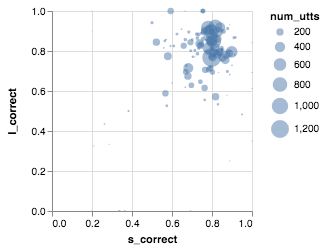

,avg_len,l_correct,l_skip,l_total,l_wrong,num_utts,s_correct,s_skip,s_total,s_wrong,total
avg_len,1.000000,0.167080,0.109255,-0.093254,-0.211446,-0.122061,0.058116,-0.036020,-0.115289,-0.054946,-0.124827
l_correct,0.167080,1.000000,-0.321904,0.232040,-0.842193,0.199509,0.334871,-0.323797,0.204593,-0.265292,0.213019
l_skip,0.109255,-0.321904,1.000000,-0.046620,-0.239371,0.049117,0.228547,-0.154927,0.048912,-0.218374,-0.039088
l_total,-0.093254,0.232040,-0.046620,1.000000,-0.211411,0.687447,0.197423,-0.167344,0.680475,-0.169705,0.905688
l_wrong,-0.211446,-0.842193,-0.239371,-0.211411,1.000000,-0.219301,-0.427697,0.386602,-0.224295,0.354054,-0.196194
num_utts,-0.122061,0.199509,0.049117,0.687447,-0.219301,1.000000,0.196970,-0.129107,0.950592,-0.181518,0.917373
s_correct,0.058116,0.334871,0.228547,0.197423,-0.427697,0.196970,1.000000,-0.713267,0.191525,-0.882810,0.213491
s_skip,-0.036020,-0.323797,-0.154927,-0.167344,0.386602,-0.129107,-0.713267,1.000000,-0.139513,0.300450,-0.155239
s_total,-0.115289,0.204593,0.048912,0.680475,-0.224295,0.950592,0.191525,-0.139513,1.000000,-0.167133,0.947539
s_wrong,-0.054946,-0.265292,-0.218374,-0.169705,0.354054,-0.181518,-0.882810,0.300450,-0.167133,1.000000,-0.186486


,WorkerId,avg_len,l_correct,l_skip,l_total,l_wrong,num_utts,s_correct,s_skip,s_total,s_wrong,total,utts
114,A2LTOGMTVG7WWO,14.200000,NaN,NaN,NaN,NaN,5.0,1.000000,0.000000,31.0,0.000000,31,"[Move the gas label down a little bit. It should still be between 2.0 and 2.5., Plot the same points but the vertical axis should be from 0.0 to 3.5, Change the color of the tick marks along the v..."
230,A3OCYH4BC5E9B4,5.600000,0.350000,0.000000,20.0,0.650000,5.0,1.000000,0.000000,11.0,0.000000,31,"[Change XYZ to Accelaration, Change circle plots to jagged plot, Change miles per gallon to blue, Move numbers under Acceleration to right side, Change precipitation to grey]"
177,A25AX0DNHKJCQT,8.600000,NaN,NaN,NaN,NaN,5.0,1.000000,0.000000,10.0,0.000000,10,"[Show only row with rating of 90, Remove numbers under Number of Records, make numbers on left side of chart blue, make ratings numbers on left side of chart gray, Rotate label on left side of ch..."
165,A1ZCKK5SH4WACZ,9.000000,0.692308,0.000000,13.0,0.307692,5.0,1.000000,0.000000,8.0,0.000000,21,"[bring the word gas closer to y axis , bring the word miles closer to the x axis, make the word miles unbolded or not as dark, create a gap between the numbers and the y axis, bold the numbers abo..."
253,A2GGN2GHIKZ0HC,3.500000,0.612245,0.061224,49.0,0.326531,4.0,1.000000,0.000000,8.0,0.000000,57,"[X axis Horsepower larger, X asis number change bigger, colour change, legand change]"
245,A6JIG6MT31475,7.200000,NaN,NaN,NaN,NaN,5.0,1.000000,0.000000,8.0,0.000000,8,"[There is a background grid on the graph now, The colored bars doubled in width., The Task label is askew, The Color label is enlarged and bolded, The Count label is replaced by three vertical dots]"
187,AL4WZDIXIVO2S,6.000000,0.841584,0.029703,202.0,0.128713,4.0,1.000000,0.000000,7.0,0.000000,209,"[change x and y-axis labels to green font, remove all y-axis labels between 0 and 50, shift y-axis label inwards, remove y-axis numerical labels]"
214,A2WPPQC8S3ICVZ,4.000000,NaN,NaN,NaN,NaN,1.0,1.000000,0.000000,2.0,0.000000,2,[Rename the axis XYZ]
263,A240XCPQTRAUL1,6.714286,0.482759,0.206897,29.0,0.310345,14.0,0.950000,0.000000,20.0,0.050000,49,"[the legend symbol changed to small size , x and y axis label name large size , x axis label merged with grid line , background color red , legend symbol circle changed to square ]"
238,A16184N1RO5OJV,7.300000,NaN,NaN,NaN,NaN,10.0,0.950000,0.050000,20.0,0.000000,20,"[Color the 5 horizontal lines red, Put 8 and 10 for the IMDB_Rating, Delete all the numbers for Rotten_Tomatoes_Rating, Bring the word miles closer to the space between 6000 and 8000, make the num..."


In [16]:
def q2row(l: QueryLine):
    return {'utterance': l.utterance(), 'workerId': l.worker_id(), 'targetFormula': l.example()['targetFormula']} 

def speaker2row(id, l: dict):
    return {'WorkerId': id, 'stats': l['stats'],
            'utts': ', '.join(l['utterances']), 'listeners': len(l['listeners'])}

def joint2row(id, l: dict):
    l['WorkerId'] = id
    return l

joint = collections.defaultdict(lambda: {'WorkerId':'', 'total': 0})

def fill_joint(rows, prefix):
    for wid, r in rows.items():
#         print('row', r)
        jr = joint[wid]
        jr['WorkerId'] = wid
        stats = r['stats']
        total = stats['correct'] + stats['wrong'] + stats['skip'] 
        correct, wrong, skip = 0.2, 0.6, 0.2
        if total != 0:
            correct = (stats['correct']) /  (total)
            wrong = (stats['wrong']) /  (total)
            skip = (stats['skip']) /  (total)
        jr[prefix + '_correct'] = correct 
        jr[prefix + '_wrong'] = wrong
        jr[prefix + '_skip'] = skip
        jr[prefix + '_total'] = total
        jr['total'] += total
        
def fill_utts(speakers):
    for wid, r in speakers.items():
#         print('row', r)
        jr = joint[wid]
        jr['WorkerId'] = wid
        utts = r['utterances']
        lenutt = len(utts)
        jr['num_utts'] = lenutt 
        jr['utts'] = utts if lenutt <= 10 else utts[0:5]
        jr['avg_len'] = np.mean([len(l.split(' ')) for l in utts])
        
fill_joint(speakers, 's')
fill_utts(speakers)
fill_joint(listeners, 'l')


records = [joint2row(k, v) for k,v in joint.items()]
agg_table = pd.DataFrame.from_records(records) 
agg_table.sort_values(by=['s_correct', 's_total', 'l_correct'], inplace=True, ascending=False)
# display(agg_table)
spec_list = []
spec_list += [{
  "data": {"values": records},
  "description": "accuracies",
  "mark": "circle",
  "encoding": {
    "x": {
      "field": "s_correct",
      "type": "quantitative"        
    },
    "y": {
      "field": "l_correct",
      "type": "quantitative"        
    },
    "size": {
        "field": "num_utts",
        "type": "quantitative"
    },
    "opacity": {"value": 0.5},
    "tooltip": {
        "field": "utts",
        "type": "nominal"
    }
  }
}]
spec_list += [{
  "data": {"values": records},
  "description": "correlation",
  "mark": "circle",
  "encoding": {
    "x": {
      "field": "s_correct",
      "type": "quantitative"        
    },
    "y": {
      "field": "l_total",
      "type": "quantitative"        
    },
    "size": {
        "field": "num_utts",
        "type": "quantitative"
    },
    "opacity": {"value": 0.5},
    "tooltip": {
        "field": "utts",
        "type": "nominal"
    }
  }
}]

chart = alt.VegaLite(spec_list[0])
display(chart)

for spec in spec_list:
    html = to_html(spec)
    name = spec['description']
    open(name + '.html', 'w').write(to_html(spec))

corr = agg_table.corr()
display(corr)
display(agg_table)

In [14]:
ex_table = pd.DataFrame.from_records([speaker2row(k, v) for k,v in speakers.items()])
ex_table.sort_values(by=['listeners'])
display(ex_table)
open('visualize.html', 'w').write(table.to_html())

,WorkerId,listeners,stats,utts
0,AZLZA0Q87TJZO,159,"{'correct': 135, 'wrong': 15, 'skip': 9}","Place green dots at each data point., Make the data line darker than the fill., The symbols in the key need to be gigantic., Extend the length of the x-axis labels., Make the background of the gr..."
1,A3GO7ZO83710SF,18,"{'correct': 8, 'wrong': 8, 'skip': 2}","Move the graph closer to the price label., Make the price label smaller., Move the date label beneath the years., Add the bars to the graph. The first on task A, between 1 and 3. The second on tas..."
2,A2AQ3REZGV9IE3,30,"{'correct': 20, 'wrong': 7, 'skip': 3}","X marker relocation needed, xyz to date, series realigned , line to bubble, Label lowered, highlight lines and separate series listings, move series label up one space. , move series listings 3 sp..."
3,A2DWSKGD9RNKMJ,712,"{'correct': 573, 'wrong': 96, 'skip': 43}","The 0 on the x axis is shifted left, change the y axis title to a slant, shift the x axis to the left so that 50 is close to 0, change the vertical lines to blue, make the x axis tick marks lighte..."
4,A1GMJEJ5DBXXBF,9,"{'correct': 8, 'wrong': 0, 'skip': 1}","Number of Records, 0 missing in origin, date (minutes-seconds), XYZ, symbol and price is covered in box"
5,AY4QOQCWAJ0RN,94,"{'correct': 75, 'wrong': 18, 'skip': 1}","At each MPG on the y axis add up all the horsepower plots and post a single plot at each increment along the y-axis to indicate the sum of horsepower at that level., Change the graph by reducing ..."
6,A1H1TKK54YG94Q,56,"{'correct': 39, 'wrong': 13, 'skip': 4}","Change font color for Horespower to green, Bold and change the font type for the Horsepower label., Extend the -next to the numbers on the Y-axis and change the font type of the Horsepower label, ..."
7,A1IU5OP7BBZHZ7,712,"{'correct': 484, 'wrong': 173, 'skip': 55}","change the yaxis value and mark the plots accordingly, change the y axis values with starting and ending values, write the yaxis title near the values, move the plot to the right slightly, Move t..."
8,AX6JQ37WUHFSH,495,"{'correct': 345, 'wrong': 114, 'skip': 36}","draw long tick marks in both the axis, draw a broad line for the yaxis, mark the title of the x axis away from the values, change the title of xaxis as binned, remove the values of xaxis and y ax..."
9,A25HKP46PWOL4M,34,"{'correct': 25, 'wrong': 9, 'skip': 0}","Move the y label up, Shift the values on the x-axis to the right, Move the values and label on the x-axis down, Move the key to the right, Shift the values on the y-axis down, Remove the 2000, 200..."


NameError: name 'table' is not defined